In [1]:
%load_ext autoreload
%autoreload 2

# Figure 4 (Time example results)

In [2]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [3]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [4]:
# general
import sys
import os

In [5]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3
pd.set_option("display.max_columns", None)

In [6]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# local
sys.path.append('..')
from utils import settings
from utils import dataloader
from utils import plot_utils

In [8]:
from dali.utils.stats import apply_fdr_bh

## Global variables

In [9]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_LINEAGE_PVAL = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'
DALIJOINT_RHO = 'DALIJOINT_RHO'

## Plot settings

In [10]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 13
sns.set_style("ticks")

In [11]:
FIGURE_NUMBER = 4
PANEL_COUNTS = 1

def save_panel(fig):
    global PANEL_COUNTS
    
    fig_dir = 'figures/fig%d' % FIGURE_NUMBER
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig.savefig(fig_dir + '/panel_%d.svg' % PANEL_COUNTS, dpi=350)
    PANEL_COUNTS += 1

## Load data

Total counts

In [12]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))

Load anndata with GP estimates

In [13]:
df_all = pd.DataFrame()
adatas_allelic = dict()

for exp_id in settings.F1_EXP_IDS:
    # all tested peaks
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
    adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
    adata_var = adata.var
    adata_var['exp_id'] = exp_id
    adata_var['base_rate'] = (adata.X.A.sum(0) / adata.layers['allelic_total'].A.sum(0)).ravel()
    
    # with GP estimates
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts_processed.h5ad'])
    adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
    adata_var = pd.merge(
        adata_var, adata.var['qdiff_10'], 
        left_index=True, right_index=True, 
        how='outer', sort=False)
    
    adata_var = adata_var.reset_index()
    df_all = pd.concat([df_all, adata_var], ignore_index=True)
    adatas_allelic[exp_id] = adata
    
df_all = df_all.rename({'index': 'peak'}, axis=1)

In [14]:
LINEAGE_COLORS = dict(zip(
    adata_total.obs['annotation'].cat.categories, 
    adata_total.uns['annotation_colors'].tolist()))
LINEAGE_COLORS['Other'] = 'gray'

## Plot time pvalue distribution and discoveries

In [15]:
df_time = df_all.query(DALIHET_PVAL + '_bh < .1').copy()

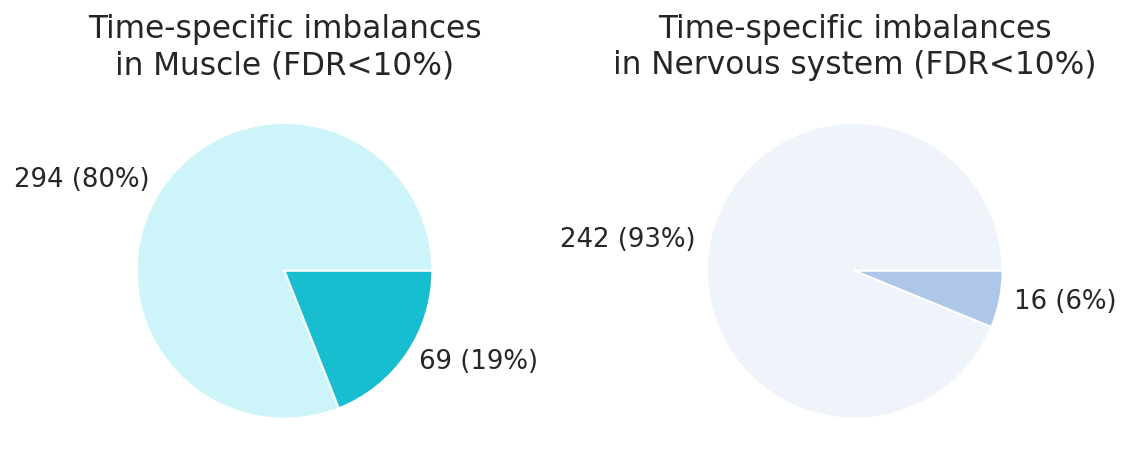

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, lineage in enumerate(['Muscle', 'Nervous system']):
    lineage_short = lineage.lower().split(' ')[0]
    df_time[DALIHET_LINEAGE_PVAL(lineage_short) + '_bh'] = apply_fdr_bh(df_time[DALIHET_LINEAGE_PVAL(lineage_short)].to_numpy())

    count = (df_time[DALIHET_LINEAGE_PVAL(lineage_short) + '_bh'].dropna() < .1).value_counts()
    frac = count.loc[True] / (df_time[DALIHET_LINEAGE_PVAL(lineage_short) + '_bh'].dropna() < .1).value_counts().sum()

    ax = axes[i]
    colors = [plot_utils.lighten_color(LINEAGE_COLORS[lineage], .2), LINEAGE_COLORS[lineage]]
    ax.pie(
        (df_time[DALIHET_LINEAGE_PVAL(lineage_short) + '_bh'].dropna() < .1).value_counts(), 
        colors=colors, labels=['%d (%d%%)' % (count.loc[False], 100 * (1 - frac)), '%d (%d%%)' % (count.loc[True], 100 * frac)])
    ax.set(title='Time-specific imbalances\nin %s (FDR<10%%)' % lineage)
plt.tight_layout()
save_panel(fig)

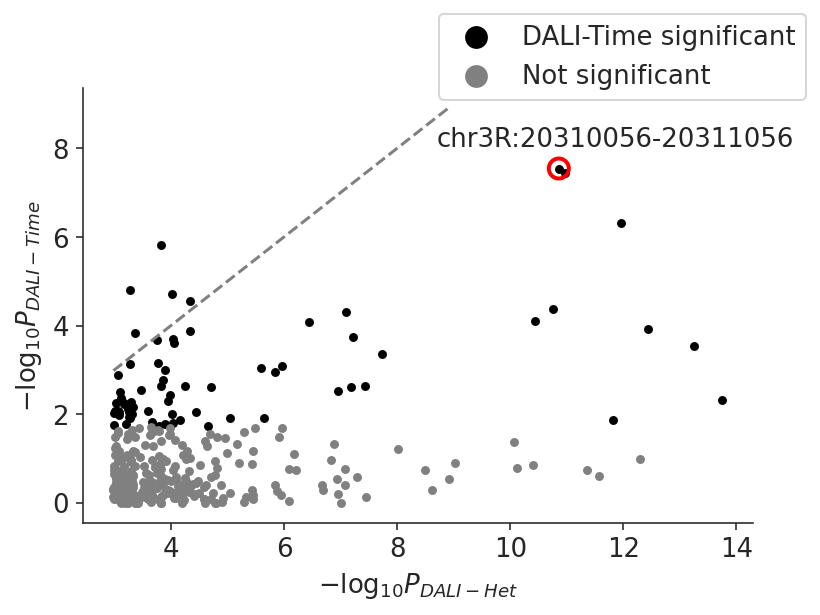

In [17]:
lineage = 'muscle'
peak_highlight = 'chr3R_20310056_20311056'
peak_highlight_exp_id = 'SS159'

peak_highlight_coords = -np.log10(df_all.query('peak == @peak_highlight and exp_id == @peak_highlight_exp_id')[[DALIHET_PVAL, DALIHET_LINEAGE_PVAL(lineage)]])

fig, ax= plt.subplots(figsize=(6, 4))

ax.scatter(
    x=-np.log10(df_time.query(DALIHET_LINEAGE_PVAL(lineage) + '_bh < .1')[DALIHET_PVAL]),
    y=-np.log10(df_time.query(DALIHET_LINEAGE_PVAL(lineage) + '_bh < .1')[DALIHET_LINEAGE_PVAL(lineage)]), 
    c='black', label='DALI-Time significant',
    rasterized=True,
    s=12)
ax.scatter(
    x=-np.log10(df_time.query(DALIHET_LINEAGE_PVAL(lineage) + '_bh >= .1')[DALIHET_PVAL]),
    y=-np.log10(df_time.query(DALIHET_LINEAGE_PVAL(lineage) + '_bh >= .1')[DALIHET_LINEAGE_PVAL(lineage)]), 
    c='grey', label='Not significant',
    rasterized=True,
    s=12)
ax.set(
    xlabel='$-\log_{10}P_{DALI-Het}$',
    ylabel='$-\log_{10}P_{DALI-Time}$')
ax.scatter(
    peak_highlight_coords[DALIHET_PVAL],
    peak_highlight_coords[DALIHET_LINEAGE_PVAL(lineage)],
    facecolors='none', edgecolors='r', s=100, linewidth=2)
ax.annotate(plot_utils.format_peak(peak_highlight),
    (peak_highlight_coords[DALIHET_PVAL] + 1,
    peak_highlight_coords[DALIHET_LINEAGE_PVAL(lineage)] + .5),
    ha='center')
plt.legend(markerscale=3, bbox_to_anchor=(1.1, 1.2))

lims = (-np.log10(df_time[DALIHET_PVAL]).max(), ax.get_ylim()[1] + 1)
ax.plot(lims, lims, c='grey', linestyle='--')
sns.despine()
save_panel(fig)

## Compare with lineage annotation

In [18]:
lineage_diff_pvals_thresholded = pd.read_csv('lineage_diff_pvals_thresholded.txt')

lineage_diff_pvals_thresholded['any'] = lineage_diff_pvals_thresholded[adata.obs['annotation'].cat.categories].sum(1) > 0
lineage_diff_pvals_thresholded = lineage_diff_pvals_thresholded[['peak', 'any', 'exp_id']]

In [19]:
df = pd.merge(df_time, lineage_diff_pvals_thresholded, left_on=['peak', 'exp_id'], right_on=['peak', 'exp_id'])

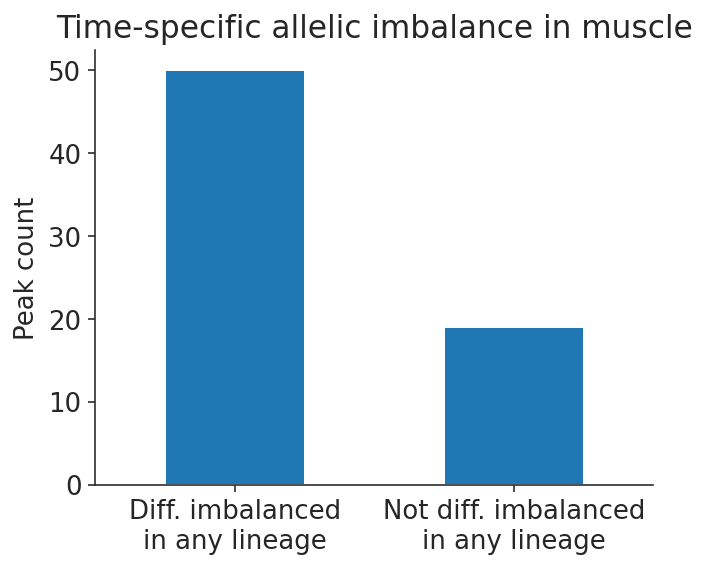

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = df.query(DALIHET_LINEAGE_PVAL('muscle') + '_bh < .1')['any'].value_counts().plot.bar(ax=ax)
ax.set_xticklabels(['Diff. imbalanced\nin any lineage', 'Not diff. imbalanced\nin any lineage'], rotation=0)
ax.set(ylabel='Peak count', title='Time-specific allelic imbalance in muscle')
sns.despine()
save_panel(fig)

In [21]:
df.query(DALIHET_LINEAGE_PVAL('muscle') + '_bh < .1')['any'].value_counts() / df.query(DALIHET_LINEAGE_PVAL('muscle') + '_bh < .1').shape[0]

True     0.724638
False    0.275362
Name: any, dtype: float64

## Plot time

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


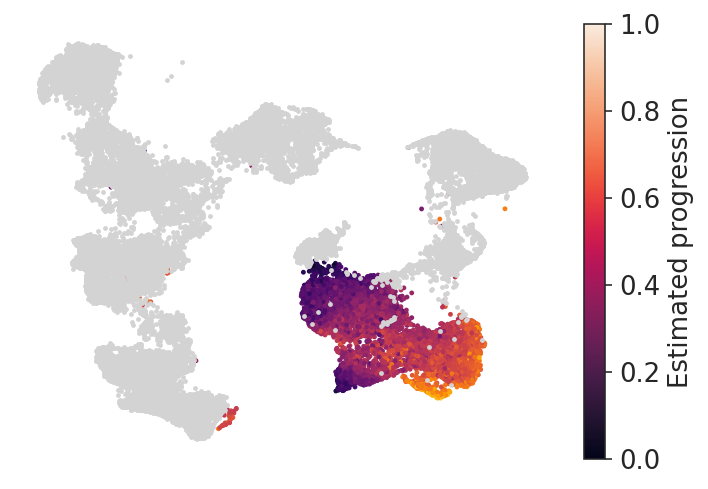

In [22]:
fig, ax = plt.subplots()
p = ax.scatter(
    adata_total[adata_total.obs['annotation'] == 'Muscle'].obsm['X_umap'][:, 0],
    adata_total[adata_total.obs['annotation'] == 'Muscle'].obsm['X_umap'][:, 1],
    c=adata_total[adata_total.obs['annotation'] == 'Muscle'].obs['time_vae'],
    cmap=plt.cm.inferno,
    rasterized=True,
    s=2)
p = ax.scatter(
    adata_total[adata_total.obs['annotation'] != 'Muscle'].obsm['X_umap'][:, 0],
    adata_total[adata_total.obs['annotation'] != 'Muscle'].obsm['X_umap'][:, 1],
    c='lightgrey',   
    rasterized=True,
    s=2)
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(p, label='Estimated progression')
sns.despine(bottom=True, left=True)
save_panel(fig)

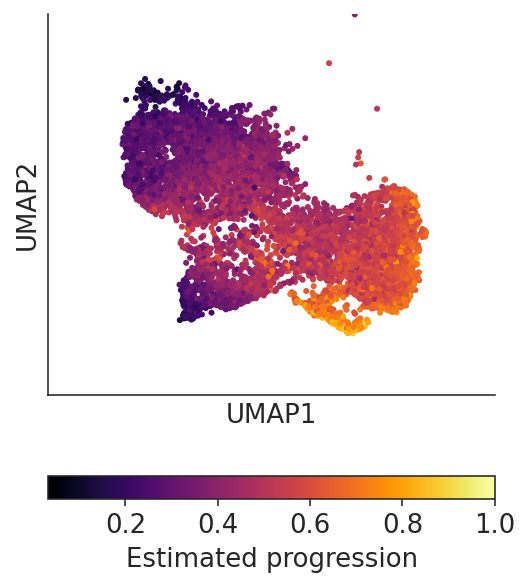

In [23]:
fig, ax = plt.subplots(figsize=(4, 5))
p = ax.scatter(
    adata_total[adata_total.obs['annotation'] == 'Muscle'].obsm['X_umap'][:, 0],
    adata_total[adata_total.obs['annotation'] == 'Muscle'].obsm['X_umap'][:, 1],
    c=adata_total[adata_total.obs['annotation'] == 'Muscle'].obs['time_vae'],
    cmap=plt.cm.inferno,
    rasterized=True,
    s=4)
ax.set(xlabel='UMAP1', ylabel='UMAP2', xlim=(4.5, 13.5), ylim=(-6.5, 2.5))
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(p, label='Estimated progression', orientation='horizontal')
sns.despine()
save_panel(fig)

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


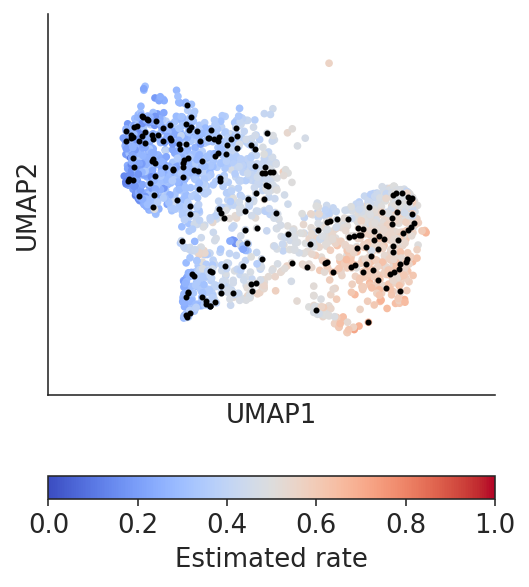

In [24]:
with plt.rc_context({'lines.markersize': np.sqrt(4)}):
    fig, ax = plt.subplots(figsize=(4, 5))
    plot_utils.plot_rate_umap(
        adata=adata[adata.obs['annotation'] == 'Muscle'],
        peak=peak_highlight,
        show_colorbar=True)    
    ax.set(xlim=(4.5, 13.5), ylim=(-6.5, 2.5))
    save_panel(fig)

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


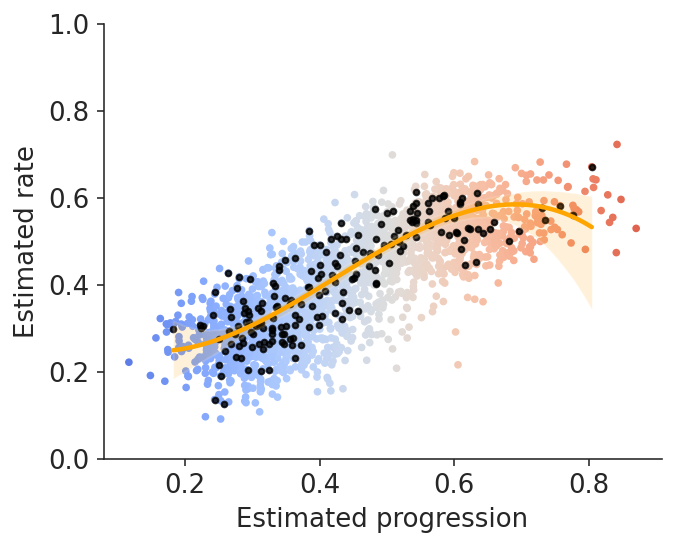

In [25]:
adata = adatas_allelic[peak_highlight_exp_id]
with plt.rc_context({'lines.markersize': np.sqrt(8)}):    
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.scatter(
        x=adata[adata.obs['annotation'] == 'Muscle'].obs['time_vae'],
        y=adata[adata.obs['annotation'] == 'Muscle', peak_highlight].layers['gp_post_mean'],
        c=adata[adata.obs['annotation'] == 'Muscle'].obs['time_vae'], 
        vmin=0, vmax=1,
        cmap=plt.cm.coolwarm,
        rasterized=True)
    plot_utils.plot_rate_time(
        adata=adata[adata.obs['annotation'] == 'Muscle', :],
        peak=peak_highlight,
        plot_covered_only=True, 
        fit_reg=True,
        ax=ax)
    ax.set(xlabel='Estimated progression')
    save_panel(fig)